In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sympy import symbols, cos, sin
from sympy.plotting import plot_parametric
from math import sin,cos

# Лабораторная работа 1 , задание 2(a) , Sigma Point Kalman Filter
Реализация сигма точечного фильтра Калмана для отслеживания координати ориентации в соответствии с odometry motion model

In [4]:
f = open('/data files/sensor_data_ekf.dat')
for line in f:
    q = line.split()
    print(q)

['ODOMETRY', '0.101373685667', '0.0996252285934', '0.000862235559071']
['SENSOR', '1', '2.29725290252', '0.353956815014']
['SENSOR', '2', '4.01825728983', '1.51507415344']
['ODOMETRY', '0.101823187296', '0.0997248889496', '-0.000206654546125']
['SENSOR', '1', '1.96846687533', '0.276209105501']
['SENSOR', '2', '3.87986704568', '1.40393072429']
['ODOMETRY', '0.100901695741', '0.0997582630735', '-0.000381616354179']
['SENSOR', '1', '1.96852886749', '0.242784804425']
['SENSOR', '2', '3.87971065887', '1.32647676387']
['ODOMETRY', '0.0997651394437', '0.0997993534855', '-0.000208097310853']
['SENSOR', '1', '1.87508331126', '0.0936569272975']
['SENSOR', '2', '3.849192179', '1.20772931615']
['ODOMETRY', '0.0988021399415', '0.100360366225', '-0.00122883669589']
['SENSOR', '1', '1.64421872619', '-0.0593514730712']
['SENSOR', '2', '3.95417280741', '1.25970767463']
['ODOMETRY', '0.0998731020684', '0.0998098334361', '0.000926085589796']
['SENSOR', '1', '1.64079501221', '-0.137553375677']
['SENSOR', 

['SENSOR', '8', '4.18501121114', '-1.96001604794']
['SENSOR', '1', '3.94177735119', '-2.84551297654']
['SENSOR', '2', '1.18038634345', '2.41547551073']
['SENSOR', '3', '2.25386927139', '-0.458608006904']
['SENSOR', '7', '4.01204561994', '-1.48975256344']
['ODOMETRY', '0.000136092271998', '0.0999996467097', '-0.000522848477433']
['SENSOR', '8', '4.40946468491', '-2.02094252774']
['SENSOR', '1', '3.91922179189', '-2.87072202395']
['SENSOR', '2', '1.44580310453', '2.32508479098']
['SENSOR', '3', '2.15756119315', '-0.424067573571']
['SENSOR', '7', '4.06104474419', '-1.57224455589']
['ODOMETRY', '0.000302269878199', '0.0999353432319', '0.000539895064198']
['SENSOR', '8', '4.5165550898', '-2.00275541219']
['SENSOR', '1', '4.25083690758', '-2.88476512783']
['SENSOR', '2', '1.59664742666', '2.36949118143']
['SENSOR', '3', '2.18656915806', '-0.37303565508']
['SENSOR', '7', '4.05007373159', '-1.58049943139']
['ODOMETRY', '0.00013361527452', '0.100074513275', '0.000560546767954']
['SENSOR', '8', 

['SENSOR', '4', '4.06515935986', '-1.72057455144']
['SENSOR', '7', '2.50287051778', '0.127838872546']
['ODOMETRY', '0.000100633095148', '0.100219327349', '0.000631070639127']
['SENSOR', '8', '0.417382565095', '0.188823271199']
['SENSOR', '1', '3.35123641832', '2.09116664517']
['SENSOR', '4', '3.95754572184', '-1.71268379099']
['SENSOR', '7', '2.41072585607', '0.122504676512']
['ODOMETRY', '-0.000607763710215', '0.100140453337', '-0.000218697666427']
['SENSOR', '8', '0.369346735302', '0.271181092817']
['SENSOR', '1', '3.67699620635', '2.07721447415']
['SENSOR', '4', '4.07710876539', '-1.73456190265']
['SENSOR', '7', '2.42576722134', '-0.0138112591739']
['ODOMETRY', '-0.000139407170528', '0.0998511677938', '0.000334065170192']
['SENSOR', '8', '0.335693906267', '0.462318775119']
['SENSOR', '1', '3.54703844972', '2.08539235736']
['SENSOR', '4', '3.94824350404', '-1.6777048794']
['SENSOR', '7', '2.13297568426', '0.0826896741318']
['ODOMETRY', '-0.000628418701319', '0.0999704949615', '-0.000

Считывание координат датчиков

In [5]:
L = []
f = open('/data files/landmarks.dat')
for line in f:
    L.append( [int(x) for x in line.split()])
print(L)
number_of_sensors = len(L)*2

[[1, 2, 1], [2, 0, 4], [3, 2, 7], [4, 9, 2], [5, 10, 5], [6, 9, 8], [7, 5, 5], [8, 5, 3], [9, 5, 9]]


In [6]:
A = np.array([[1,2,3],[4,5,6],[7,8,9]])
print(A[1:3][0] + np.array([0,1,0]))

[4 6 6]


In [7]:
print(L[0])

[1, 2, 1]


In [8]:
def conc(Y,x):
    if len(Y) == 0:
        return x
    else:
        return np.vstack((Y,x))

In [9]:
def cholesky(P):
    n = len(P)
    A = [[0.0] * n for i in range(0,n)]
    for i in range(0,n):
        sum =0 
        for k in range(0,i):
            sum+= A[i][k]*A[i][k]
        A[i][i] = math.sqrt(P[i][i] - sum)
        for j in range(i+1,n):
            sum =0
            for k in range(0,i):
                sum += A[j][k] * A[i][k]
            A[j][i] = (P[j][i] - sum)/A[i][i]
    return A

In [20]:
def nrml(ang):
    while ang >  math.pi:
        ang-= 2*math.pi
    while ang < -math.pi:
        ang+= 2*math.pi
    return ang

In [11]:
def gensigma(n,m,P):
    sqP = cholesky(P)
    sigma = np.array([[0.0] * n for i in range(0,2 * n + 1)])
    sigma[0] = m
    for i in range(1,n+1 ):
        sigma[i] = m + math.sqrt(n + delta )* np.array(sqP[:][i - 1])
        sigma[i+n] = m - math.sqrt( n + delta ) * np.array(sqP[:][i - 1])
    return sigma


# Сигма точечный фильтр для расстояний

In [21]:
# Начальные распределения
m = []
P = []
m.append([0,0,0])
P.append([[1,0,0],[0,1,0],[0,0,1]])
Y = []
f = open('/data files/sensor_data_ekf.dat')
X = []
m_ = []
p_ = []
R = []
n = 3
k = 0
nn =0 
alpha = 1
beta = 0
nums = []
kappa = 1
# Генерация сигма точек
delta = alpha * alpha * ( n + kappa ) - n
wm = []
wm.append( delta / (delta + n))
for i in range(1,2*n+1):
    wm.append(1 / (2*(delta + n)))
wc = []
wc.append(delta / (delta + n) + (1 - alpha * alpha +  beta * beta))
for i in range(1,2*n+1):
    wc.append(1 / (2 * (delta +  n )))
for line in f:
    nn = nn+1
    print("num = ")
    print(nn)
    print(line)
    q = line.split()
    if q[0] == 'ODOMETRY':
        if(len(nums)!= 0):
            # Новый прогноз
            # Прогноз матожидания
            sigma = gensigma(n,m[-1],P[-1])
            sigmax = np.array([[0.0]* n for i in range(0,2 * n + 1)])
            for i in range(0,len(sigmax)):
                sigma[i][0] = nrml(sigma[i][0])
                sigmax[i] = np.array([sigma[i][0] + deltar1 + deltar2 , 
                                      sigma[i][1] + deltat * cos(sigma[i][0] + deltar1),
                                      sigma[i][2] + deltat * sin(sigma[i][0] + deltar1)]) 
                sigmax[i][0] = nrml(sigmax[i][0])
            m_ = [0.0] * n
            for i in range(0,2*n+1):
                m_ = m_ + wm[i] * sigmax[i]
            m_[0] = nrml(m_[0])
            # Прогноз матрицы ковариации
            p_ =   np.array([[0.2,0,0],[0,0.2,0],[0,0,0.2]])
            for i in range(0,2*n+1):
                p_ = p_ + wc[i] * np.outer(np.array( sigmax[i]  - m_),np.array(sigmax[i] - m_))
            
            # Коррекция с конечной матрицей
        
            R = np.array([[0.0] * ( k)  for i in range(k)])
            for i in range(k):
                R[i][i] = 0.2
            sigma = gensigma(n,m_,p_)
            mu =  np.array([0.0]*(k))
            S  =  R
            C =  np.array([[0.0] * (k)  for i in range(n)])
            sigmax = np.array([[0.0]*k for i in range(2*n+1)])
            for i in range(2*n+1):
                for j in range(0,k):
                    num = nums[j]
                    delta_x = L[num - 1][1] - sigma[i][1]
                    delta_y = L[num - 1][2] - sigma[i][2]
                    qq = (delta_x * delta_x) + (delta_y * delta_y)
                    sigmax[i][j] = (math.sqrt(qq))

                mu = mu + wm[i]  * sigmax[i]
            for i in range(2*n+1):
                S = S + wc[i] * np.outer(np.array(sigmax[i] - mu),     np.array(sigmax[i] - mu)) 
                C = C + wc[i] * np.outer(np.array(sigma[i]  - m_ ), np.array(sigmax[i] - mu))
            
            K = np.dot(C, np.linalg.inv(S))
            v = np.array(Y) - np.array(mu)
            v = np.dot(K , v.transpose())
            v = v.tolist();
            new_ang= m_+ v
            new_ang[0] = nrml(new_ang[0])
            m.append(new_ang)
            P.append(p_  - np.dot(np.dot(K ,S),K.transpose()))
           # print("m = ")
           # print(m[-1])
           # print("P = ")
           # print(P[-1])
        
        #Берем дельты из Одометрии
        deltar1 = float(q[1])
        deltat = float(q[2])
        deltar2 = float(q[3])
        nums = []
        Y = []
        R = []
        k = 0
    else:
        k = k+1
        num = int(q[1])
        nums.append(num)
        Y.append(float(q[2]))
    #    Y.append(float(q[3]))
       

num = 
1
ODOMETRY 0.101373685667 0.0996252285934 0.000862235559071

num = 
2
SENSOR 1 2.29725290252 0.353956815014

num = 
3
SENSOR 2 4.01825728983 1.51507415344

num = 
4
ODOMETRY 0.101823187296 0.0997248889496 -0.000206654546125

sqP = 
[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]
sigma = 
[[ 0.  0.  0.]
 [ 2.  0.  0.]
 [ 0.  2.  0.]
 [ 0.  0.  2.]
 [-2.  0.  0.]
 [ 0. -2.  0.]
 [ 0.  0. -2.]]
sigmax = 
[[ 0.10223592  0.09911376  0.01008209]
 [ 2.10223592 -0.05041349  0.08592826]
 [ 0.10223592  2.09911376  0.01008209]
 [ 0.10223592  0.09911376  2.01008209]
 [-1.89776408 -0.03207826 -0.09431952]
 [ 0.10223592 -1.90088624  0.01008209]
 [ 0.10223592  0.09911376 -1.98991791]]
sqP = 
[[1.0954451150103324, 0.0, 0.0], [-0.0041844252011476535, 1.0971314448189138, 0.0], [0.04113573874831966, 0.00031110853161275923, 1.0956169748066202]]
m = 
[0.10567613 0.21387904 0.11335925]
P = 
[[ 1.19860396 -0.00321138  0.00802   ]
 [-0.00321138  0.4049782  -0.04441321]
 [ 0.00802    -0.04441321  0.

m = 
[0.17131364 1.00201615 3.40346096]
P = 
[[ 2.06926073e+00 -5.71215279e-02  5.13454396e-02]
 [-5.71215279e-02  6.45806586e-02  5.38274535e-04]
 [ 5.13454396e-02  5.38274535e-04  7.21872241e-02]]
num = 
177
SENSOR 8 4.19218444921 -1.62918746421

num = 
178
SENSOR 1 2.56469838469 -2.73365039673

num = 
179
SENSOR 2 1.07742306684 1.02436797734

num = 
180
SENSOR 3 3.79502409217 -0.2864736654

num = 
181
SENSOR 7 4.23474402594 -1.08843934559

num = 
182
ODOMETRY 0.000760851469688 0.0999197195975 -0.000675084333497

sqP = 
[[1.438492520147925, 0.0, 0.0], [-0.03970929783326944, 0.25100563788625485, 0.0], [0.035693921827035215, 0.007791279607865863, 0.2661812615445494]]
sigma = 
[[ 0.17131364  1.00201615  3.40346096]
 [ 3.04829868  1.00201615  3.40346096]
 [ 0.09189504  1.50402743  3.40346096]
 [ 0.24270148  1.01759871  3.93582348]
 [-2.7056714   1.00201615  3.40346096]
 [ 0.25073224  0.50000487  3.40346096]
 [ 0.0999258   0.98643359  2.87109843]]
sigmax = 
[[ 0.17193401  1.10064697  3.42

[[ 0.25732504  1.17120364  4.79903531]
 [ 3.1343351   0.9745125   4.77420884]
 [ 0.170838    1.67235574  4.79058766]
 [ 0.32095206  1.13633909  5.33699495]
 [-2.61968502  0.98784929  4.72363677]
 [ 0.34381208  0.66932872  4.80729233]
 [ 0.19369802  1.20567686  4.26097247]]
sqP = 
[[1.5073748101340372, 0.0, 0.0], [-0.010741411713443855, 0.5194538797867834, 0.0], [0.017862612061115366, -0.007274102854644, 0.5221487025263761]]
m = 
[0.26180843 1.06561659 4.88331819]
P = 
[[ 2.27185473 -0.01186431  0.02000942]
 [-0.01186431  0.06185757 -0.00326053]
 [ 0.02000942 -0.00326053  0.06955618]]
num = 
273
SENSOR 8 4.5165550898 -2.00275541219

num = 
274
SENSOR 1 4.25083690758 -2.88476512783

num = 
275
SENSOR 2 1.59664742666 2.36949118143

num = 
276
SENSOR 3 2.18656915806 -0.37303565508

num = 
277
SENSOR 7 4.05007373159 -1.58049943139

num = 
278
ODOMETRY 0.00013361527452 0.100074513275 0.000560546767954

sqP = 
[[1.5072673061300008, 0.0, 0.0], [-0.00787140179645762, 0.24858722509802134, 0.0], 

[[1.4377348002608838, 0.0, 0.0], [-0.04784474768947098, 0.29494224509869826, 0.0], [0.03139260931233215, -0.1412491793555931, 0.3151330984707076]]
sigma = 
[[ 0.35838907  1.14816434  6.30285291]
 [ 3.23385867  1.14816434  6.30285291]
 [ 0.26269958  1.73804883  6.30285291]
 [ 0.42117429  0.86566598  6.9331191 ]
 [-2.51708053  1.14816434  6.30285291]
 [ 0.45407857  0.55827985  6.30285291]
 [ 0.29560385  1.4306627   5.67258671]]
sigmax = 
[[ 0.35812839  1.24175774  6.33790073]
 [-3.04958732  1.04864831  6.29365325]
 [ 0.2624389   1.83456266  6.32879815]
 [ 0.42091361  0.95687593  6.97397029]
 [-2.51734121  1.06708297  6.24442444]
 [ 0.45381789  0.64809649  6.34668264]
 [ 0.29534317  1.52627073  5.70169305]]
sqP = 
[[1.4392813522201704, 0.0, 0.0], [0.06263827987058324, 0.5573766391546734, 0.0], [0.03409985421537736, -0.08329476617048767, 0.5423337282051598]]
m = 
[-0.40783048  1.19923066  6.55815883]
P = 
[[ 2.06762785  0.06515325  0.03543563]
 [ 0.06515325  0.08662968 -0.03658252]
 [ 0.03

sigma = 
[[-0.1409082   1.86122429  8.33476999]
 [ 2.73683174  1.86122429  8.33476999]
 [-0.06429668  2.46431789  8.33476999]
 [-0.06943772  1.88120976  8.87022072]
 [-3.01864815  1.86122429  8.33476999]
 [-0.21751972  1.25813068  8.33476999]
 [-0.21237869  1.84123881  7.79931926]]
sigmax = 
[[-0.17126224  1.96008559  8.31974606]
 [ 2.7064777   1.76970261  8.3750572 ]
 [-0.09465072  2.56403909  8.32735663]
 [-0.09979176  1.98089153  8.86229479]
 [-3.04900219  1.76186607  8.32349077]
 [-0.24787376  1.35555212  8.31222362]
 [-0.24273273  1.93877488  7.77727403]]
sqP = 
[[1.5076773979709273, 0.0, 0.0], [0.009795335534588848, 0.5462250725075731, 0.0], [0.01882871919759561, 0.005064156202610765, 0.5230132837548727]]
m = 
[-0.16940254  1.78454189  8.44254175]
P = 
[[2.27275845e+00 1.09454447e-02 2.10150660e-02]
 [1.09454447e-02 9.11022953e-02 3.93633622e-05]
 [2.10150660e-02 3.93633622e-05 6.95967781e-02]]
num = 
469
SENSOR 9 3.11237333983 -0.828608726065

num = 
470
SENSOR 2 5.1348537585 -2

sqP = 
[[1.4399691039393638, 0.0, 0.0], [-0.05102585687728423, 0.5712861295261777, 0.0], [0.048463785469211436, 0.021597755000637278, 0.5337293830703919]]
m = 
[0.13019699 3.45884058 9.5098038 ]
P = 
[[ 2.07011174 -0.05514392  0.05112509]
 [-0.05514392  0.12177305  0.00801516]
 [ 0.05112509  0.00801516  0.08828333]]
num = 
550
SENSOR 9 1.71819656468 -0.707245929411

num = 
551
SENSOR 3 3.02406315637 -2.3968858507

num = 
552
SENSOR 7 4.90173372979 -1.65060778383

num = 
553
ODOMETRY -0.00884110158486 0.100015505449 -0.0206146468981

sqP = 
[[1.4387882902864595, 0.0, 0.0], [-0.03832663949180345, 0.34684883831853625, 0.0], [0.03553343324795152, 0.027034928824673007, 0.29375128532900835]]
sigma = 
[[ 0.13019699  3.45884058  9.5098038 ]
 [ 3.00777357  3.45884058  9.5098038 ]
 [ 0.05354371  4.15253826  9.5098038 ]
 [ 0.20126386  3.51291044 10.09730637]
 [-2.74737959  3.45884058  9.5098038 ]
 [ 0.20685027  2.76514291  9.5098038 ]
 [ 0.05913013  3.40477073  8.92230123]]
sigmax = 
[[ 0.0998168

sigma = 
[[ 0.62767074  5.50351638  9.81051982]
 [ 3.49151702  5.50351638  9.81051982]
 [ 0.50916997  6.13310735  9.81051982]
 [ 0.65131329  5.41368171 10.37067319]
 [-2.23617554  5.50351638  9.81051982]
 [ 0.74617151  4.87392541  9.81051982]
 [ 0.60402819  5.59335106  9.25036645]]
sigmax = 
[[ 0.62847849  5.58454284  9.86933893]
 [-2.79086054  5.40946764  9.77617148]
 [ 0.50997773  6.22051938  9.85934719]
 [ 0.65212104  5.49329502 10.43139135]
 [-2.23536778  5.44172276  9.73173834]
 [ 0.74697926  4.94742982  9.87850567]
 [ 0.60483595  5.67574537  9.30725363]]
sqP = 
[[1.43996074187333, 0.0, 0.0], [0.05224777934192169, 0.5526648181449878, 0.0], [0.048574868930848905, -0.02450009781256341, 0.5278797521930465]]
m = 
[-0.1559765  5.5405842  9.854164 ]
P = 
[[ 2.06973228  0.05517936  0.05066643]
 [ 0.05517936  0.09810395 -0.01303914]
 [ 0.05066643 -0.01303914  0.08363303]]
num = 
655
SENSOR 9 1.24742332493 -2.3761257833

num = 
656
SENSOR 3 4.78533958114 -2.48110189333

num = 
657
SENSOR 6

sigma = 
[[ 0.70385503  8.246318    9.11858373]
 [ 3.56474747  8.246318    9.11858373]
 [ 0.58378865  8.93161528  9.11858373]
 [ 0.70972628  8.4703031   9.76689652]
 [-2.15703741  8.246318    9.11858373]
 [ 0.82392141  7.56102072  9.11858373]
 [ 0.69798378  8.0223329   8.47027094]]
sigmax = 
[[ 0.67354114  8.32330192  9.18254885]
 [-2.74875172  8.15462693  9.07844884]
 [ 0.55347476  9.01570659  9.17286735]
 [ 0.67941239  8.54691014  9.83131252]
 [-2.1873513   8.19006725  9.03579536]
 [ 0.79360752  7.62978879  9.19130933]
 [ 0.66766989  8.09969105  8.53378297]]
sqP = 
[[1.4400908233766585, 0.0, 0.0], [0.04831786687814112, 0.5784067830023014, 0.0], [0.05105529194896353, 0.06163502507357612, 0.5494505496706362]]
m = 
[-0.11078651  8.37119086  9.07813718]
P = 
[[2.07112162 0.05183258 0.05847654]
 [0.05183258 0.11916799 0.04335986]
 [0.05847654 0.04335986 0.12295494]]
num = 
756
SENSOR 9 3.50551920675 -2.39732140232

num = 
757
SENSOR 5 4.28281556549 -0.589616154158

num = 
758
SENSOR 6 1.2

[[-0.30980823  9.80513726  6.76927678]
 [ 2.56721886  9.80513726  6.76927678]
 [-0.21957545 11.34107115  6.76927678]
 [-0.24976135  9.96380538  7.26085892]
 [-3.18683532  9.80513726  6.76927678]
 [-0.40004101  8.26920337  6.76927678]
 [-0.36985511  9.64646915  6.27769463]]
sigmax = 
[[-0.31026322  9.90033099  6.73875984]
 [ 2.56676387  9.72123556  6.82362412]
 [-0.22003044 11.43862751  6.74746193]
 [-0.25021634 10.06065889  7.23610964]
 [ 3.095895    9.70527581  6.77383971]
 [-0.400496    8.36125994  6.73030605]
 [-0.3703101   9.73965997  6.24152004]]
sqP = 
[[1.439092233084887, 0.0, 0.0], [-0.05107054597555508, 0.8957028583139269, 0.0], [0.028701174782329156, 0.025309263833485644, 0.5110846753990831]]
m = 
[0.4710109  9.79782247 6.63012712]
P = 
[[ 2.06925226 -0.05667828  0.0281581 ]
 [-0.05667828  0.54138051  0.05159077]
 [ 0.0281581   0.05159077  0.06916935]]
num = 
877
SENSOR 4 4.50322759327 -0.208257404441

num = 
878
SENSOR 5 1.40431609203 0.102953443634

num = 
879
SENSOR 6 1.92


num = 
996
ODOMETRY -0.00080944386785 0.100013043879 1.97022648298e-05

sqP = 
[[1.4379437078900463, 0.0, 0.0], [0.0494396181063128, 0.3384425716237032, 0.0], [0.021649416926604898, -0.0008919923638493523, 0.27140613615149495]]
sigma = 
[[-0.4868444   9.79359662  4.33330814]
 [ 2.38904301  9.79359662  4.33330814]
 [-0.38796517 10.47048176  4.33330814]
 [-0.44354557  9.79181263  4.87612041]
 [-3.36273182  9.79359662  4.33330814]
 [-0.58572364  9.11671147  4.33330814]
 [-0.53014324  9.7953806   3.79049586]]
sigmax = 
[[-0.48652814  9.88204591  4.28643123]
 [ 2.38935928  9.72056062  4.4017659 ]
 [-0.3876489  10.56312662  4.29539176]
 [-0.4432293   9.88220811  4.833116  ]
 [ 2.92076976  9.69594182  4.35531413]
 [-0.58540737  9.20010113  4.27792865]
 [-0.52982697  9.88171792  3.73983434]]
sqP = 
[[1.4391364134945277, 0.0, 0.0], [-0.059925219028670235, 0.5641045787890255, 0.0], [0.04085312793049115, 0.0018528069676519146, 0.5241881149191715]]
m = 
[0.29151618 9.88731677 4.28188491]
P = 
[[ 

sqP = 
[[1.4335913398895648, 0.0, 0.0], [0.06884093428020804, 0.822878237821597, 0.0], [0.02103030080014706, -0.057489656107853886, 0.5614897579908795]]
m = 
[-0.59291826  9.50686732  2.29478933]
P = 
[[ 2.05341728  0.0844645   0.01761555]
 [ 0.0844645   0.54023611 -0.09750079]
 [ 0.01761555 -0.09750079  0.14055173]]
num = 
1080
SENSOR 4 1.10312028502 -1.48363601494

num = 
1081
SENSOR 5 3.00416166275 3.10884116279

num = 
1082
ODOMETRY -0.000984233781833 0.0999672948533 7.64590930276e-05

sqP = 
[[1.432974974939192, 0.0, 0.0], [0.05894346092381142, 0.7326402795881762, 0.0], [0.01229299421085207, -0.13407040937690046, 0.3498938893716918]]
sigma = 
[[-0.59291826  9.50686732  2.29478933]
 [ 2.27303169  9.50686732  2.29478933]
 [-0.47503134 10.97214787  2.29478933]
 [-0.56833227  9.2387265   2.99457711]
 [-3.45886821  9.50686732  2.29478933]
 [-0.71080518  8.04158676  2.29478933]
 [-0.61750425  9.77500813  1.59500155]]
sigmax = 
[[-0.59350289  9.58967772  2.23889631]
 [ 2.27244706  9.4423

m = 
[-0.75061342  8.17659575  1.32393752]
P = 
[[2.04588082 0.08589409 0.00730451]
 [0.08589409 0.09635337 0.01216672]
 [0.00730451 0.01216672 0.0836204 ]]
num = 
1179
SENSOR 8 3.31329949365 -0.442208158787

num = 
1180
SENSOR 4 1.14087202904 -2.42970915883

num = 
1181
SENSOR 5 4.28986062879 -2.13951007973

num = 
1182
SENSOR 7 4.50725975692 -0.916450378366

num = 
1183
ODOMETRY 0.000123003750952 0.0998768096926 -0.000338091992771

sqP = 
[[1.4303429013645672, 0.0, 0.0], [0.0600513973046328, 0.30454424702753335, 0.0], [0.005106821304696513, 0.03894361144839158, 0.2864920803908792]]
sigma = 
[[-0.75061342  8.17659575  1.32393752]
 [ 2.11007239  8.17659575  1.32393752]
 [-0.63051062  8.78568425  1.32393752]
 [-0.74039977  8.25448298  1.89692168]
 [-3.61129922  8.17659575  1.32393752]
 [-0.87071621  7.56750726  1.32393752]
 [-0.76082706  8.09870853  0.75095336]]
sigmax = 
[[-0.75035838  8.24976543  1.2557801 ]
 [ 2.11032742  8.12518909  1.40970809]
 [-0.63025558  8.86649306  1.26503786]

m = 
[0.04021417 5.22129    1.43833099]
P = 
[[ 2.45327809e+00 -4.27793599e-03  1.00535097e-02]
 [-4.27793599e-03  7.33060144e-02  1.26003681e-03]
 [ 1.00535097e-02  1.26003681e-03  8.12077454e-02]]
num = 
1327
SENSOR 8 1.42956896486 -0.405210773852

num = 
1328
SENSOR 1 3.11530262765 1.08617098938

num = 
1329
SENSOR 4 3.75792044617 -1.94960186471

num = 
1330
SENSOR 7 3.44632621596 -0.561375582074

num = 
1331
ODOMETRY -0.000298257136816 0.0996631664365 -0.198915852019

sqP = 
[[1.5662943810446885, 0.0, 0.0], [-0.0027312464624234547, 0.27073705817579113, 0.0], [0.006418659141900886, 0.004718850667456156, 0.28485834839071816]]
sigma = 
[[ 0.04021417  5.22129     1.43833099]
 [ 3.17280294  5.22129     1.43833099]
 [ 0.03475168  5.76276412  1.43833099]
 [ 0.05305149  5.2307277   2.00804769]
 [-3.09237459  5.22129     1.43833099]
 [ 0.04567667  4.67981588  1.43833099]
 [ 0.02737686  5.2118523   0.8686143 ]]
sigmax = 
[[-0.15888871  5.32175227  1.44243264]
 [ 2.97370005  5.12079487  1.435

m = 
[-0.61048606  4.99653827  3.37071316]
P = 
[[2.0500765  0.08382976 0.01844583]
 [0.08382976 0.08355785 0.01014215]
 [0.01844583 0.01014215 0.07447356]]
num = 
1436
SENSOR 8 0.556611108037 3.00403808456

num = 
1437
SENSOR 1 4.07609954779 2.29923731693

num = 
1438
SENSOR 3 4.61268174855 0.746177069223

num = 
1439
SENSOR 4 4.26511409215 -1.93342631232

num = 
1440
SENSOR 7 1.5749019735 0.109768246387

num = 
1441
ODOMETRY 2.93556084258e-05 0.100060189388 0.00098238378032

sqP = 
[[1.4318088199140377, 0.0, 0.0], [0.05854815090004316, 0.28307235813688936, 0.0], [0.012882882715308555, 0.033164232433738255, 0.2705692641906409]]
sigma = 
[[-0.61048606  4.99653827  3.37071316]
 [ 2.25313158  4.99653827  3.37071316]
 [-0.49338975  5.56268298  3.37071316]
 [-0.58472029  5.06286673  3.91185169]
 [-3.4741037   4.99653827  3.37071316]
 [-0.72758236  4.43039355  3.37071316]
 [-0.63625182  4.9302098   2.82957463]]
sigmax = 
[[-0.60999758  5.07839769  3.31339548]
 [ 2.25362006  4.93354966  3.44

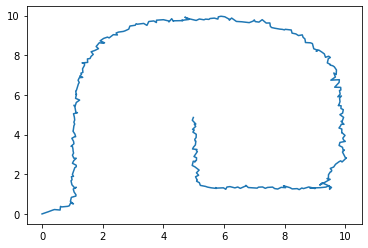

In [22]:
X =[]
for i in range(0,len(m)):
    X.append(m[i])#np.random.multivariate_normal(m[i],P[i]))
x = [a[1] for a in X]
y = [a[2] for a in X]
fig1 = plt.figure(1)
axes1 = fig1.subplots(1, 1)
axes1.plot(x, y,label='parametric curve')

print(P)

# Сигма точечный фильтр для расстояния и угла

In [23]:
# Начальные распределения
m = []
P = []
m.append([0,0,0])
P.append([[1,0,0],[0,1,0],[0,0,1]])
Y = []
f = open('/data files/sensor_data_ekf.dat')
X = []
m_ = []
p_ = []
R = []
n = 3
k = 0
nn =0 
alpha = 1
beta = 0
nums = []
kappa = 1
# Генерация сигма точек
delta = alpha * alpha * ( n + kappa ) - n
wm = []
wm.append( delta / (delta + n))
for i in range(1,2*n+1):
    wm.append(1 / (2*(delta + n)))
wc = []
wc.append(delta / (delta + n) + (1 - alpha * alpha +  beta * beta))
for i in range(1,2*n+1):
    wc.append(1 / (2 * (delta +  n )))
for line in f:
    nn = nn+1
    print("num = ")
    print(nn)
    print(line)
    q = line.split()
    if q[0] == 'ODOMETRY':
        if(len(nums)!= 0):
            # Новый прогноз
            sigma = gensigma(n,m[-1],P[-1])
            sigmax = np.array([[0.0]* n for i in range(0,2 * n + 1)])
            for i in range(0,len(sigmax)):
                sigma[i][0] = nrml(sigma[i][0])
                sigmax[i] = np.array([sigma[i][0] + deltar1 + deltar2 , 
                                      sigma[i][1] + deltat * cos(sigma[i][0] + deltar1),
                                      sigma[i][2] + deltat * sin(sigma[i][0] + deltar1)]) 
                sigmax[i][0] = nrml(sigmax[i][0])
            m_ = [0.0] * n
            for i in range(0,2*n+1):
                m_ = m_ + wm[i] * sigmax[i]
                m_[0] = nrml(m_[0])
            # Прогноз матрицы ковариации
            p_ =   np.array([[0.2,0,0],[0,0.2,0],[0,0,0.2]])
            for i in range(0,2*n+1):
                p_ = p_ + wc[i] * np.outer(np.array( sigmax[i]  - m_),np.array(sigmax[i] - m_))
            
            # Коррекция с конечной матрицей
        
            R = np.array([[0.0] * (2 * k)  for i in range(2 * k)])
            for i in range(k):
                R[2*i][2*i] = 0.2
                R[2*i+1][2*i+1] = 1
            sigma = gensigma(n,m_,p_)
            mu =  np.array([0.0] * (2 * k))
            S  =  R
            C =  np.array([[0.0] * (2 * k)  for i in range(n)])
            sigmax = np.array([[0.0] * (2 * k) for i in range(2 * n+1)])
            for i in range(2 * n + 1):
                for j in range(0,k):
                    num = nums[j]
                    delta_x = L[num - 1][1] - sigma[i][1]
                    delta_y = L[num - 1][2] - sigma[i][2]
                    qq = (delta_x * delta_x) + (delta_y * delta_y)
                    phi = math.atan2(delta_y,delta_x)  - sigma[i][0]
                    phi = nrml(phi)
                    sigmax[i][2*j] = (math.sqrt(qq))
                    sigmax[i][2*j+1] = (phi)
                mu = mu + wm[i]  * sigmax[i]
            for i in range(2*n+1):
                S = S + wc[i] * np.outer(np.array(sigmax[i] - mu),     np.array(sigmax[i] - mu)) 
                C = C + wc[i] * np.outer(np.array(sigma[i]  - m_ ), np.array(sigmax[i] - mu))
        
            K = np.dot(C, np.linalg.inv(S))
            v = np.array(Y) - np.array(mu)
            v = np.dot(K , v.transpose())
            v = v.tolist();
            v[0] = nrml(v[0])
            new_ang= m_+ v
            new_ang[0] = nrml(new_ang[0])
            m.append(new_ang)
            P.append(p_  - np.dot(np.dot(K ,S),K.transpose()))
      #      print("m = ")
      #      print(m[-1])
      #      print("P = ")
      #      print(P[-1])
        
        #Берем дельты из Одометрии
        deltar1 = float(q[1])
        deltat = float(q[2])
        deltar2 = float(q[3])
        nums = []
        Y = []
        R = []
        k = 0
    else:
        k = k+1
        num = int(q[1])
        nums.append(num)
        Y.append(float(q[2]))
        Y.append(float(q[3]))
       

num = 
1
ODOMETRY 0.101373685667 0.0996252285934 0.000862235559071

num = 
2
SENSOR 1 2.29725290252 0.353956815014

num = 
3
SENSOR 2 4.01825728983 1.51507415344

num = 
4
ODOMETRY 0.101823187296 0.0997248889496 -0.000206654546125

sqP = 
[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]
sigma = 
[[ 0.  0.  0.]
 [ 2.  0.  0.]
 [ 0.  2.  0.]
 [ 0.  0.  2.]
 [-2.  0.  0.]
 [ 0. -2.  0.]
 [ 0.  0. -2.]]
sqP = 
[[1.0954451150103324, 0.0, 0.0], [-0.0041844252011476535, 1.0971314448189138, 0.0], [0.04113573874831966, 0.00031110853161275923, 1.0956169748066202]]
m = 
[0.24694747 0.29175534 0.136811  ]
P = 
[[ 0.54213942  0.03547871 -0.0242843 ]
 [ 0.03547871  0.36358715 -0.04999541]
 [-0.0242843  -0.04999541  0.20796392]]
num = 
5
SENSOR 1 1.96846687533 0.276209105501

num = 
6
SENSOR 2 3.87986704568 1.40393072429

num = 
7
ODOMETRY 0.100901695741 0.0997582630735 -0.000381616354179

sqP = 
[[0.7363011780365769, 0.0, 0.0], [0.04818505052074062, 0.6010535364783677, 0.0], [-0.03298147204792130

m = 
[1.40255442 0.99787701 3.00013391]
P = 
[[0.1232345  0.00796055 0.00332184]
 [0.00796055 0.06296796 0.00130371]
 [0.00332184 0.00130371 0.06374295]]
num = 
153
SENSOR 8 3.97991042562 -1.60690152056

num = 
154
SENSOR 1 2.35643859208 -2.67866850272

num = 
155
SENSOR 2 1.45749408492 0.830132685583

num = 
156
SENSOR 3 4.02815458891 -0.258831937496

num = 
157
SENSOR 7 4.42145324114 -1.10938279886

num = 
158
ODOMETRY 0.000696732375949 0.100156157706 -0.000584089998119

sqP = 
[[0.3510477123692497, 0.0, 0.0], [0.022676541004405002, 0.24990746023434768, 0.0], [0.00946264631390041, 0.004358115642509584, 0.25225863600680265]]
sigma = 
[[1.40255442 0.99787701 3.00013391]
 [2.10464985 0.99787701 3.00013391]
 [1.44790751 1.49769193 3.00013391]
 [1.42147972 1.00659324 3.50465119]
 [0.700459   0.99787701 3.00013391]
 [1.35720134 0.49806209 3.00013391]
 [1.38362913 0.98916078 2.49561664]]
sqP = 
[[0.5690678901035182, 0.0, 0.0], [-0.009702036971433245, 0.5121281339123687, 0.0], [0.00753441879

m = 
[1.51083417 1.03117063 5.52115757]
P = 
[[ 0.06601219  0.00321472 -0.00693927]
 [ 0.00321472  0.06730097  0.00019165]
 [-0.00693927  0.00019165  0.0616711 ]]
num = 
303
SENSOR 8 4.77404605226 -2.08170107067

num = 
304
SENSOR 1 4.33976416105 -2.90292850512

num = 
305
SENSOR 2 1.88969783614 2.58825155721

num = 
306
SENSOR 3 1.73764363829 -0.49745195748

num = 
307
SENSOR 7 3.96406958388 -1.66060095497

num = 
308
ODOMETRY -0.000283673180471 0.0998692948249 -6.45801742076e-05

sqP = 
[[0.25692837703208715, 0.0, 0.0], [0.012512106276293355, 0.2591223948749776, 0.0], [-0.02700856957007688, 0.002043765036733196, 0.24685513974011622]]
sigma = 
[[1.51083417 1.03117063 5.52115757]
 [2.02469092 1.03117063 5.52115757]
 [1.53585838 1.54941542 5.52115757]
 [1.45681703 1.03525816 6.01486785]
 [0.99697741 1.03117063 5.52115757]
 [1.48580996 0.51292584 5.52115757]
 [1.56485131 1.0270831  5.02744729]]
sqP = 
[[0.5166219183871638, 0.0, 0.0], [-0.006181089960298631, 0.516801664877873, 0.0], [-0.0

sqP = 
[[0.2677320546449223, 0.0, 0.0], [-0.03802883927552095, 0.24432707196610373, 0.0], [-0.025205827372819973, -0.04906056746434029, 0.29565961506330934]]
sigma = 
[[2.1883638  1.25218311 7.41094839]
 [2.72382791 1.25218311 7.41094839]
 [2.11230613 1.74083725 7.41094839]
 [2.13795215 1.15406197 8.00226762]
 [1.6528997  1.25218311 7.41094839]
 [2.26442148 0.76352896 7.41094839]
 [2.23877546 1.35030424 6.81962916]]
sqP = 
[[0.5232226862766785, 0.0, 0.0], [-0.026405895226039252, 0.5130150061180803, 0.0], [-0.021908086428231936, -0.026741953560675453, 0.5360136374324276]]
m = 
[1.34506257 1.23104985 7.54433425]
P = 
[[ 0.07241402 -0.00935471 -0.01203147]
 [-0.00935471  0.0600726  -0.010533  ]
 [-0.01203147 -0.010533    0.0887617 ]]
num = 
419
SENSOR 9 4.12881342913 -0.867651605124

num = 
420
SENSOR 2 4.0288094419 -3.2276561161

num = 
421
SENSOR 3 0.901200006923 -2.03251122022

num = 
422
SENSOR 7 4.62001856502 -1.8309460386

num = 
423
ODOMETRY -0.00943323576827 0.100124414548 -0.0203

m = 
[0.30592627 2.74876029 9.23013502]
P = 
[[ 0.18536767 -0.00209989 -0.00896446]
 [-0.00209989  0.10664609  0.01392246]
 [-0.00896446  0.01392246  0.08870398]]
num = 
518
SENSOR 9 2.24529394017 -0.685502521964

num = 
519
SENSOR 3 2.31844097149 -2.42828855555

num = 
520
SENSOR 7 4.95528000197 -1.57288604154

num = 
521
ODOMETRY -0.00983384980744 0.0999224766995 -0.0204305528243

sqP = 
[[0.43054346119830195, 0.0, 0.0], [-0.004877307976330142, 0.3265306993951554, 0.0], [-0.020821271196990173, 0.042326522989220475, 0.29407298072546056]]
sigma = 
[[ 0.30592627  2.74876029  9.23013502]
 [ 1.16701319  2.74876029  9.23013502]
 [ 0.29617166  3.40182169  9.23013502]
 [ 0.26428373  2.83341333  9.81828098]
 [-0.55516065  2.74876029  9.23013502]
 [ 0.31568089  2.09569889  9.23013502]
 [ 0.34756881  2.66410724  8.64198905]]
sqP = 
[[0.6211481187671491, 0.0, 0.0], [-0.011663267446931917, 0.5556543242266077, 0.0], [0.015326124258030857, 0.022009159018479826, 0.5347207607423746]]
m = 
[0.26402828

m = 
[-0.12483323  5.25235163  9.87774225]
P = 
[[ 0.17509236 -0.00734003 -0.01336523]
 [-0.00734003  0.09642473 -0.0138953 ]
 [-0.01336523 -0.0138953   0.06555608]]
num = 
635
SENSOR 9 0.926859129886 -2.02052805263

num = 
636
SENSOR 3 4.5099200538 -2.5031268995

num = 
637
SENSOR 6 4.1118649023 -0.581633953961

num = 
638
SENSOR 7 4.76898001883 -1.59231791735

num = 
639
ODOMETRY -0.000339024488948 0.100009711461 2.26344713328e-05

sqP = 
[[0.4184403872589866, 0.0, 0.0], [-0.017541402438594783, 0.31002745743912064, 0.0], [-0.03194058020720259, -0.0466267954608574, 0.24972349400647878]]
sigma = 
[[-0.12483323  5.25235163  9.87774225]
 [ 0.71204755  5.25235163  9.87774225]
 [-0.15991603  5.87240654  9.87774225]
 [-0.18871439  5.15909804 10.37718924]
 [-0.961714    5.25235163  9.87774225]
 [-0.08975042  4.63229671  9.87774225]
 [-0.06095207  5.34560522  9.37829526]]
sqP = 
[[0.6135309765227313, 0.0, 0.0], [-0.003255106409500138, 0.5462634521242151, 0.0], [0.012329167019957624, -0.021871

[-0.73114475  8.01746128  9.2461337 ]
P = 
[[ 0.22401794 -0.03001752 -0.03954074]
 [-0.03001752  0.10425294  0.04269655]
 [-0.03954074  0.04269655  0.13094492]]
num = 
740
SENSOR 9 3.05939885103 -2.42259296594

num = 
741
SENSOR 5 4.85625275968 -0.554387962083

num = 
742
SENSOR 6 1.69976007626 -0.4523568891

num = 
743
ODOMETRY -0.0112125747693 0.100293480859 -0.0200290197221

sqP = 
[[0.4733053298704608, 0.0, 0.0], [-0.06342104367994165, 0.31659233492281164, 0.0], [-0.083541722921119, 0.11812743988042664, 0.33167998097684726]]
sigma = 
[[-0.73114475  8.01746128  9.2461337 ]
 [ 0.21546591  8.01746128  9.2461337 ]
 [-0.85798683  8.65064595  9.2461337 ]
 [-0.89822819  8.25371616  9.90949366]
 [-1.67775541  8.01746128  9.2461337 ]
 [-0.60430266  7.38427661  9.2461337 ]
 [-0.5640613   7.7812064   8.58277374]]
sqP = 
[[0.6595599923690549, 0.0, 0.0], [-0.024604733446033443, 0.5572406321561985, 0.0], [-0.019290115790014863, 0.06345201317425465, 0.5501277077035822]]
m = 
[-0.76216723  8.04151

 [-1.81884982  9.68889579  6.34415954]]
sqP = 
[[0.6640492563212113, 0.0, 0.0], [0.07699776688228994, 0.6518661215070917, 0.0], [0.009611987091792331, 0.03695425264980634, 0.553912287414496]]
m = 
[-1.89640548 10.07358493  7.15468067]
P = 
[[0.26096836 0.04348863 0.00575357]
 [0.04348863 0.22566208 0.05252571]
 [0.00575357 0.05252571 0.10960942]]
num = 
861
SENSOR 4 4.99272912579 -0.274166164371

num = 
862
SENSOR 5 1.81092330137 0.0761110639692

num = 
863
SENSOR 6 1.36882473059 -2.60089763233

num = 
864
ODOMETRY -0.0104826202942 0.0999751788151 -0.0191967893743

sqP = 
[[0.5108506270109445, 0.0, 0.0], [0.0851298370358874, 0.4673489013302392, 0.0], [0.01126272637631934, 0.1103392238472148, 0.3119420168574506]]
sigma = 
[[-1.89640548 10.07358493  7.15468067]
 [-0.87470423 10.07358493  7.15468067]
 [-1.72614581 11.00828274  7.15468067]
 [-1.87388003 10.29426338  7.7785647 ]
 [-2.91810674 10.07358493  7.15468067]
 [-2.06666516  9.13888713  7.15468067]
 [-1.91893094  9.85290649  6.530796

[[0.6181009990825468, 0.0, 0.0], [0.059333314371591124, 0.5288769763712635, 0.0], [0.017637608230487663, -0.00938424126871848, 0.5132057835882593]]
m = 
[-1.36999368  9.8788354   4.147328  ]
P = 
[[ 0.15234821  0.05456532  0.01646354]
 [ 0.05456532  0.06286956 -0.00135264]
 [ 0.01646354 -0.00135264  0.05818964]]
num = 
997
SENSOR 4 2.14265941231 -0.576114496391

num = 
998
SENSOR 5 1.06875104344 3.01158775394

num = 
999
SENSOR 6 4.04413273461 -2.9178294235

num = 
1000
SENSOR 7 5.0221824592 -1.79251846775

num = 
1001
ODOMETRY -0.000993208621031 0.0998844685408 -0.000121644357505

sqP = 
[[0.3903180823768112, 0.0, 0.0], [0.1397970688254966, 0.20814981058832924, 0.0], [0.04217979866481367, -0.034827086559237865, 0.23494165172785297]]
sigma = 
[[-1.36999368  9.8788354   4.147328  ]
 [-0.58935751  9.8788354   4.147328  ]
 [-1.09039954 10.29513502  4.147328  ]
 [-1.28563408  9.80918123  4.6172113 ]
 [-2.15062984  9.8788354   4.147328  ]
 [-1.64958782  9.46253578  4.147328  ]
 [-1.45435328

[ 0.01413032 10.30948766  1.78758865]
P = 
[[ 2.05352994 -0.09794505  0.042458  ]
 [-0.09794505  0.13634002  0.02004755]
 [ 0.042458    0.02004755  0.10679559]]
num = 
1104
SENSOR 4 0.953865121238 -1.2816545328

num = 
1105
SENSOR 5 3.75050538274 -2.21025810438

num = 
1106
ODOMETRY 0.000643301288042 0.0998677942291 -0.202643646401

sqP = 
[[1.4330142830965413, 0.0, 0.0], [-0.06834897168711689, 0.36286145648995577, 0.0], [0.029628456204146832, 0.060829351216799346, 0.3197147672101361]]
sigma = 
[[ 0.01413032 10.30948766  1.78758865]
 [ 2.88015888 10.30948766  1.78758865]
 [-0.12256763 11.03521057  1.78758865]
 [ 0.07338723 10.43114636  2.42701818]
 [-2.85189825 10.30948766  1.78758865]
 [ 0.15082826  9.58376474  1.78758865]
 [-0.0451266  10.18782896  1.14815911]]
sqP = 
[[1.5030234073048967, 0.0, 0.0], [-0.015502929357095026, 0.585201257620185, 0.0], [0.019706495246298156, 0.029974583668502242, 0.550524868927897]]
m = 
[-0.37773447 10.29866256  1.65113178]
P = 
[[ 2.25106217 -0.0044968

[2.06771385 7.21259842 1.51373287]
P = 
[[ 0.65362261 -0.02340995  0.07768439]
 [-0.02340995  0.0665794   0.0050745 ]
 [ 0.07768439  0.0050745   0.09536838]]
num = 
1219
SENSOR 8 2.93905607509 -0.585176239548

num = 
1220
SENSOR 4 2.0438034489 -2.72800462462

num = 
1221
SENSOR 5 4.52648542497 -2.21078238898

num = 
1222
SENSOR 7 4.18292097158 -1.01609850061

num = 
1223
ODOMETRY -0.000473674854813 0.10002979275 -7.07593512027e-05

sqP = 
[[0.8084693013948792, 0.0, 0.0], [-0.028955886557706458, 0.2563999858789784, 0.0], [0.09608823185214646, 0.03064280672182075, 0.29188431547956034]]
sigma = 
[[2.06771385 7.21259842 1.51373287]
 [3.68465245 7.21259842 1.51373287]
 [2.00980208 7.7253984  1.51373287]
 [2.25989031 7.27388404 2.0975015 ]
 [0.45077525 7.21259842 1.51373287]
 [2.12562562 6.69979845 1.51373287]
 [1.87553739 7.15131281 0.92996424]]
sqP = 
[[1.625350642331158, 0.0, 0.0], [-0.0006695957155534056, 0.5195570226998882, 0.0], [0.06128245848416355, 0.01344603584781456, 0.529866436068

m = 
[1.8956121  5.14757884 1.59899082]
P = 
[[ 0.22913497 -0.01497188  0.0015078 ]
 [-0.01497188  0.07693033 -0.00522592]
 [ 0.0015078  -0.00522592  0.07838534]]
num = 
1332
SENSOR 8 1.41119753152 -0.218291775829

num = 
1333
SENSOR 1 3.14171978452 1.37417197214

num = 
1334
SENSOR 4 3.97964357546 -1.84339806385

num = 
1335
SENSOR 7 3.37769084878 -0.326486102096

num = 
1336
ODOMETRY -0.000223643982462 0.0996312038275 -0.2025564277

sqP = 
[[0.4786804418792084, 0.0, 0.0], [-0.03127740456151116, 0.2755940106657698, 0.0], [0.003149911012729152, -0.01860489672516714, 0.2793372108024022]]
sigma = 
[[1.8956121  5.14757884 1.59899082]
 [2.85297299 5.14757884 1.59899082]
 [1.8330573  5.69876687 1.59899082]
 [1.90191193 5.11036905 2.15766524]
 [0.93825122 5.14757884 1.59899082]
 [1.95816691 4.59639082 1.59899082]
 [1.88931228 5.18478864 1.0403164 ]]
sqP = 
[[0.6558377569286222, 0.0, 0.0], [-0.04156219328558243, 0.527013777883732, 0.0], [-0.008188735968550501, -0.009375873887449425, 0.5275305

m = 
[2.03367378 5.17670573 3.51010007]
P = 
[[ 0.09422023 -0.01888046 -0.00933805]
 [-0.01888046  0.06590459  0.00333884]
 [-0.00933805  0.00333884  0.06613287]]
num = 
1436
SENSOR 8 0.556611108037 3.00403808456

num = 
1437
SENSOR 1 4.07609954779 2.29923731693

num = 
1438
SENSOR 3 4.61268174855 0.746177069223

num = 
1439
SENSOR 4 4.26511409215 -1.93342631232

num = 
1440
SENSOR 7 1.5749019735 0.109768246387

num = 
1441
ODOMETRY 2.93556084258e-05 0.100060189388 0.00098238378032

sqP = 
[[0.3069531352480338, 0.0, 0.0], [-0.06150927283739107, 0.24924125683693038, 0.0], [-0.030421738336233878, 0.005888338062298485, 0.2552894783029187]]
sigma = 
[[2.03367378 5.17670573 3.51010007]
 [2.64758005 5.17670573 3.51010007]
 [1.91065523 5.67518825 3.51010007]
 [1.9728303  5.18848241 4.02067902]
 [1.41976751 5.17670573 3.51010007]
 [2.15669233 4.67822322 3.51010007]
 [2.09451726 5.16492906 2.99952111]]
sqP = 
[[0.546744090088755, 0.0, 0.0], [-0.043597973452639785, 0.5135517333583782, 0.0], [-0.

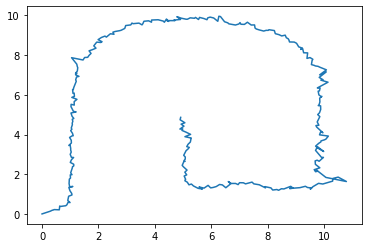

In [24]:
X =[]
for i in range(0,len(m)):
    X.append(m[i])#np.random.multivariate_normal(m[i],P[i]))
x = [a[1] for a in X]
y = [a[2] for a in X]
fig1 = plt.figure(1)
axes1 = fig1.subplots(1, 1)
axes1.plot(x, y,label='parametric curve')